In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
import bout.assembly as bt
import comparison.data_assembly as comp
import comparison.plot as complot
from core import SITE_NAMES

from cli import get_file_paths
import plot
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [16]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = [6, 18, 30, 60, 120, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

site_key = 'Carp'
type_keys = ['LF', 'HF']
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]
data_params['metric_tag'] = 'call_rate'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['start'] = dt.datetime(2022, 8, 8, 0, 0, 0)
data_params['end'] = dt.datetime(2022, 8, 16, 16, 0, 0)

# for type_key in type_keys:
type_key = "LF"
print(site_key, type_key)
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)

activity_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_callrate_TYPE_SITE_summary"]}.csv', index_col=0)
callrate_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["cont_callrate_TYPE_SITE_summary"]}.csv', index_col=0)
activity_arr.index = pd.DatetimeIndex(activity_arr.index)
callrate_arr.index = pd.DatetimeIndex(callrate_arr.index)

Carp LF


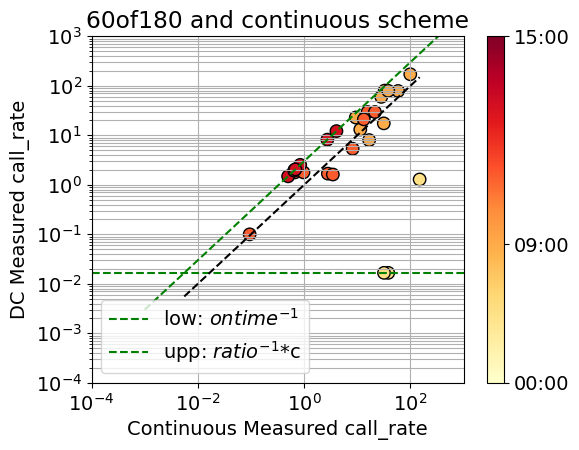

In [17]:
plt.figure(figsize=(6, 4.5))
plt.rcParams.update({'font.size':14})
prev_cycle = 0
dc_col = '60of180'
dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
time_on = int(dc_col.split('of')[0])
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'

cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
callrate_cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, callrate_cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, callrate_cont_column, data_params)
complot.plot_indiv_dc_control_comp_over_cycle_log_scale(plt_dcmetr, plt_cmetr, data_params)

In [18]:
lowest_vals = plt_dcmetr[plt_dcmetr==plt_dcmetr.replace(0,np.NaN).min()].dropna()

In [19]:
lowest_vals

,call_rate (60of180)
datetime_UTC,
2022-08-08 03:00:00,0.016667
2022-08-13 03:00:00,0.016667


In [20]:
location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)

In [21]:
location_df['call_start_time'] = pd.to_datetime(location_df['call_start_time'])
location_df['call_end_time'] = pd.to_datetime(location_df['call_end_time'])

In [22]:
call_in_sum1 = location_df[(location_df['call_start_time']>=lowest_vals.index[0])&(location_df['call_end_time']<=(lowest_vals.index[0]+ pd.Timedelta(minutes=time_on)))]
call_in_sum2 = location_df[(location_df['call_start_time']>=lowest_vals.index[1])&(location_df['call_end_time']<=(lowest_vals.index[1]+ pd.Timedelta(minutes=time_on)))]

In [23]:
call_in_sum1['input_file'].item()

'/mnt/ubna_data_01_mir/recover-20220808/UBNA_013/20220808_030000.WAV'

In [24]:
call_in_sum2['input_file'].item()

'/mnt/ubna_data_01_mir/recover-20220815/UBNA_005/20220813_030000.WAV'

In [25]:
def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)
        
    plt.yticks(ticks=np.linspace(0, 1, 11), labels=np.linspace(0, fs/2000, 11).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.ylim(0, 0.5)
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

In [26]:
site_key = 'Carp'
freq_key = 'LF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[22])
file_path

PosixPath('../data/audiomoth_recordings/recover-20220808/Carp/20220808_030000.WAV')

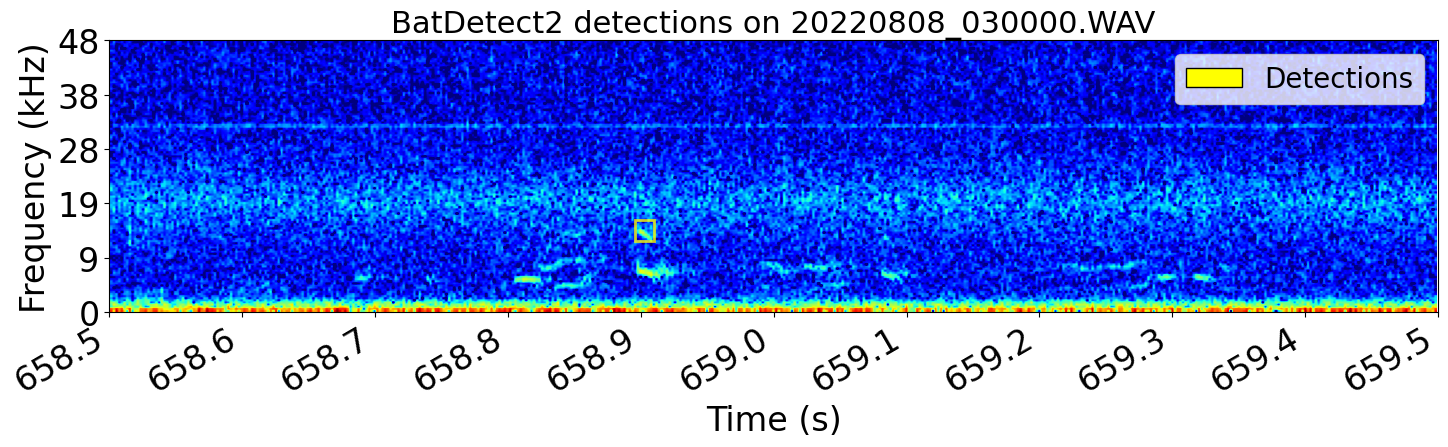

In [27]:
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 658.5
duration = 1
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 35 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 512
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

plot_dets = call_in_sum1
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets)

In [28]:
site_key = 'Carp'
freq_key = 'LF'

files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
file_path = Path(files_from_loc[23])
file_path

PosixPath('../data/audiomoth_recordings/recover-20220815/Carp/20220813_030000.WAV')

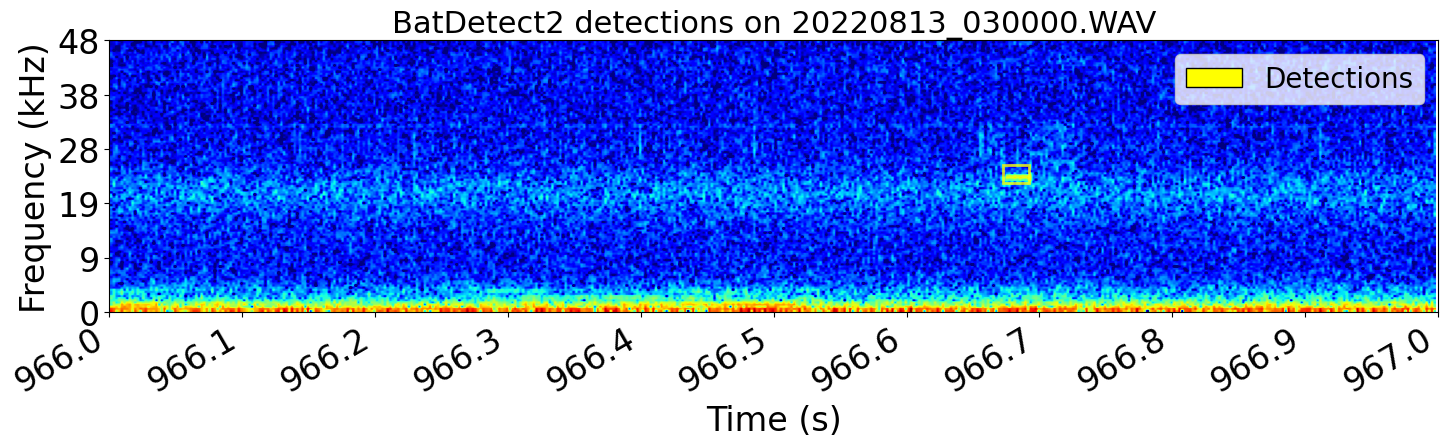

In [29]:
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 966
duration = 1
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 40 # hide anything below -rm_dB dB

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 512
spec_features['cmap'] = 'jet'
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '6of6'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
file_paths = get_file_paths(data_params)

plot_dets = call_in_sum2
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets)